In [34]:
#configuraciones
library(repr)
options(repr.plot.width=30,repr.plot.height=10)
IRdisplay::display_html("<style>.container { width:95% !important; }</style>")
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

<div style="text-align:left">
    <img style='height:100px' src='https://upload.wikimedia.org/wikipedia/commons/4/47/Logo_UTFSM.png' align='left'>
<div>

<div style='float:right;'>
    <div style="text-align:center">
        UNIVERSIDAD TÉCNICA FEDERICO SANTA MARÍA <br>
        CAMPUS SANTIAGO <br>
        DEPARTAMENTO DE INFORMÁTICA <br>
        PRIMER SEMESTRE 2020
    </div>
</div>

<div style="padding:50px;"></div>
<hr style="height:2px;border:none"/>

# Ayudantía Árboles de Clasificación (en R)

<hr style="height:2px;border:none"/>
    
* _**Profesor - Nicolás Rojas**_
* _**Francisca Ramírez - francisca.ramirez.12@sansano.usm.cl**_
* _**Felipe Vega - felipe.vega.14@sansano.usm.cl**_
    
<hr style="height:2px;border:none"/>

El objetivo de este notebook es mostrar una manera de utilizar árboles de clasificación en R. Para esto, se realizará un pequeño ejercicio de clasificación utilizando un dataset de Pokémon con los datos de [Smogon University](https://www.smogon.com/), la cual es una comunidad especializada en las batallas competitivas. 

El dataset original fue subido a la plataforma Kaggle por el usuario Gibs. Este puede ser descargado en el siguiente [link](https://www.kaggle.com/notgibs/smogon-6v6-pokemon-tiers). Para efectos de la ayudantía se subirá a aula una versión lista para ser utilizada.

## Antes de comenzar

Es necesario instalar R antes de seguir con la ayudantía, puedes descargarlo en el siguiente [link](https://cran.r-project.org/mirrors.html). 

Se recomienda [R Studio](https://rstudio.com/) como entorno de desarrollo, pero en caso de querer utilizar Jupyter pueden instalar el kernel de R siguiendo el siguiente [tutorial](https://gist.github.com/aaizemberg/de26054c0e2964be96bb468b9ce1c019). 

## Librería

Para construir los árboles de clasificación es necesario instalar el paquete `tree`. Para esto deben utilizar el siguiente comando.

In [2]:
install.packages('tree')

Installing package into 'C:/Users/felip/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'tree' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\felip\AppData\Local\Temp\RtmpqwIa6H\downloaded_packages


Si utilizar R Studio, puedes instalarlo seleccionando _**Tools**_ $\leftarrow$ _**Install Packages**_ en la barra de herramientas.

_**Nota:**_ Existen otros paquetes para la construcción de árboles, pero se recomienda utilizar el paquete antes mencionado.

Una vez instalado, se debe importar el paquete con el comando `library`.

In [3]:
library(tree)

## Dataset

El dataset a utilizar está compuesto por 15 columnas, las cuales se describen a continuación.

- _**DexNum:**_ (Int) Corresponde al número en la Pokedex del Pokémon.
- _**Name:**_ (String) Nombre del Pokémon
- _**Type1:**_ (String) Tipo primario del Pokémon, puede tomar uno de los siguientes valores: Water; Normal; Psychic; Bug; Grass; Fire; Electric; Dragon; Rock; Dark; Ground; Steel; Ghost; Fighting; Ice; Poison; Fairy; Flying.
- _**Type2:**_ (String) Tipo secundario del Pokémon, puede tomar los mismos valores anteriores o el valor "NoType".
- _**Total:**_ (Int) Suma de los stats base del Pokémon.
- _**HP:**_ (Int) Health Point, stat de vida del Pokémon.
- _**Atk:**_ (Int) Stat de ataque del Pokémon.
- _**Def:**_ (Int) Stat de defensa del Pokémon.
- _**SAtk:**_ (Int) Stat de ataque especial del Pokémon.
- _**SDef:**_ (Int) Stat de defensa especial del Pokémon.
- _**Spd:**_ (Int) Stat de velocidad del Pokémon.
- _**Generation:**_ (Int) Generación en la cual fue creado el Pokémon. Toma valores del 1 al 6.
- _**Legendary:**_ (Boolean) indica si el Pokémon es legendario o no.
- _**Mega:**_ (Boolean) indica si el Pokémon es una mega evolución o no.
- _**Tier:**_ (String) clasificación entregada por Smogon a cada Pokémon según su aptitud en el juego competitivo. Puede tomar los valores PU, NU (NeverUsed), RU (RarelyUsed), UU (UnderUsed), OU (OverUsed) y Uber.

El objetivo de este ejercicio es predecir la clasificación (tier) de cada Pokémon basado en los otros atributos. Esto podría ser útil para Smogon cuando sale un nuevo juego y hay que armar nuevamente las clasificaciones, tener un modelo que prediga una posible clase podría crear una clasificación inicial sobre la cual se puede iterar para llegar a nuevas clasificaciones.

# Manos a la obra

## Lectura de datos

Primero se deben cargar los datos en memoria, para esto se debe usar el siguiente comando.

In [4]:
data <- read.table("smogon_cleaned.csv",header=TRUE,sep=';')

La línea anterior guarda una tabla con el dataset en la variable `data`. El primer parámetro corresponde a la ruta del archivo a leer, mientras los otros dos indican si el archivo cuenta con encabezados y el símbolo de separación de los datos.

Para ver los datos de una determinada columna se puede utilizar lo siguiente `variable_con_datos$nombre_columna`. Por ejemplo, podemos ver los datos de la variable `Name`. Por temas de espacio se mostrarán solo los primeros 10 Pokémon del dataset.

In [5]:
data$Name[0:10]

[1] "Mega Rayquaza"   "Mega Gengar"     "Mega Kangaskhan" "Mewtwo"         
 [5] "Mega Mewtwo X"   "Mega Mewtwo Y"   "Lugia"           "Ho-oh"          
 [9] "Blaziken"        "Mega Blaziken"

## Breve exploración de datos

Una de las fases más importantes al momento de realizar un trabajo de predicción a partir de datos es conocer los datos con los que se van a trabajar. Para lo anterior se realiza un proceso de Análisis Exploratorio de Datos (EDA: exploratory data analysis).

A continuación se muestra una pequeña exploración del dataset a utilizar.

In [6]:
dim(data)

[1] 499  15

Nuestro dataset cuenta con 499 registros, cada uno con 15 atributos. Si alguien conoce de Pokémon, puede saber que existen muchos más, esto se debe a que Smogon no considera a todos los Pokémon existente para sus clasificaciones en partidas competitivas.

### Cantidad de Pokémon por cada tier 

Una de las cosas importantes a conocer sobre el dataset es cuantos datos tenemos por cada clase a clasificar. Para esto, podemos utilizar el comando `xtabs`, con el cual podemos ver la cantidad de registros por cada valor posible de una columna. Esta función recibe como parámetros la columna a analizar y la tabla con los datos.

In [7]:
xtabs(~Tier,data=data)

Tier
  NU   OU   PU   RU Uber   UU 
  65   74  179   55   40   86 

También podemos ver esta misma información mediante un gráfico de barras.

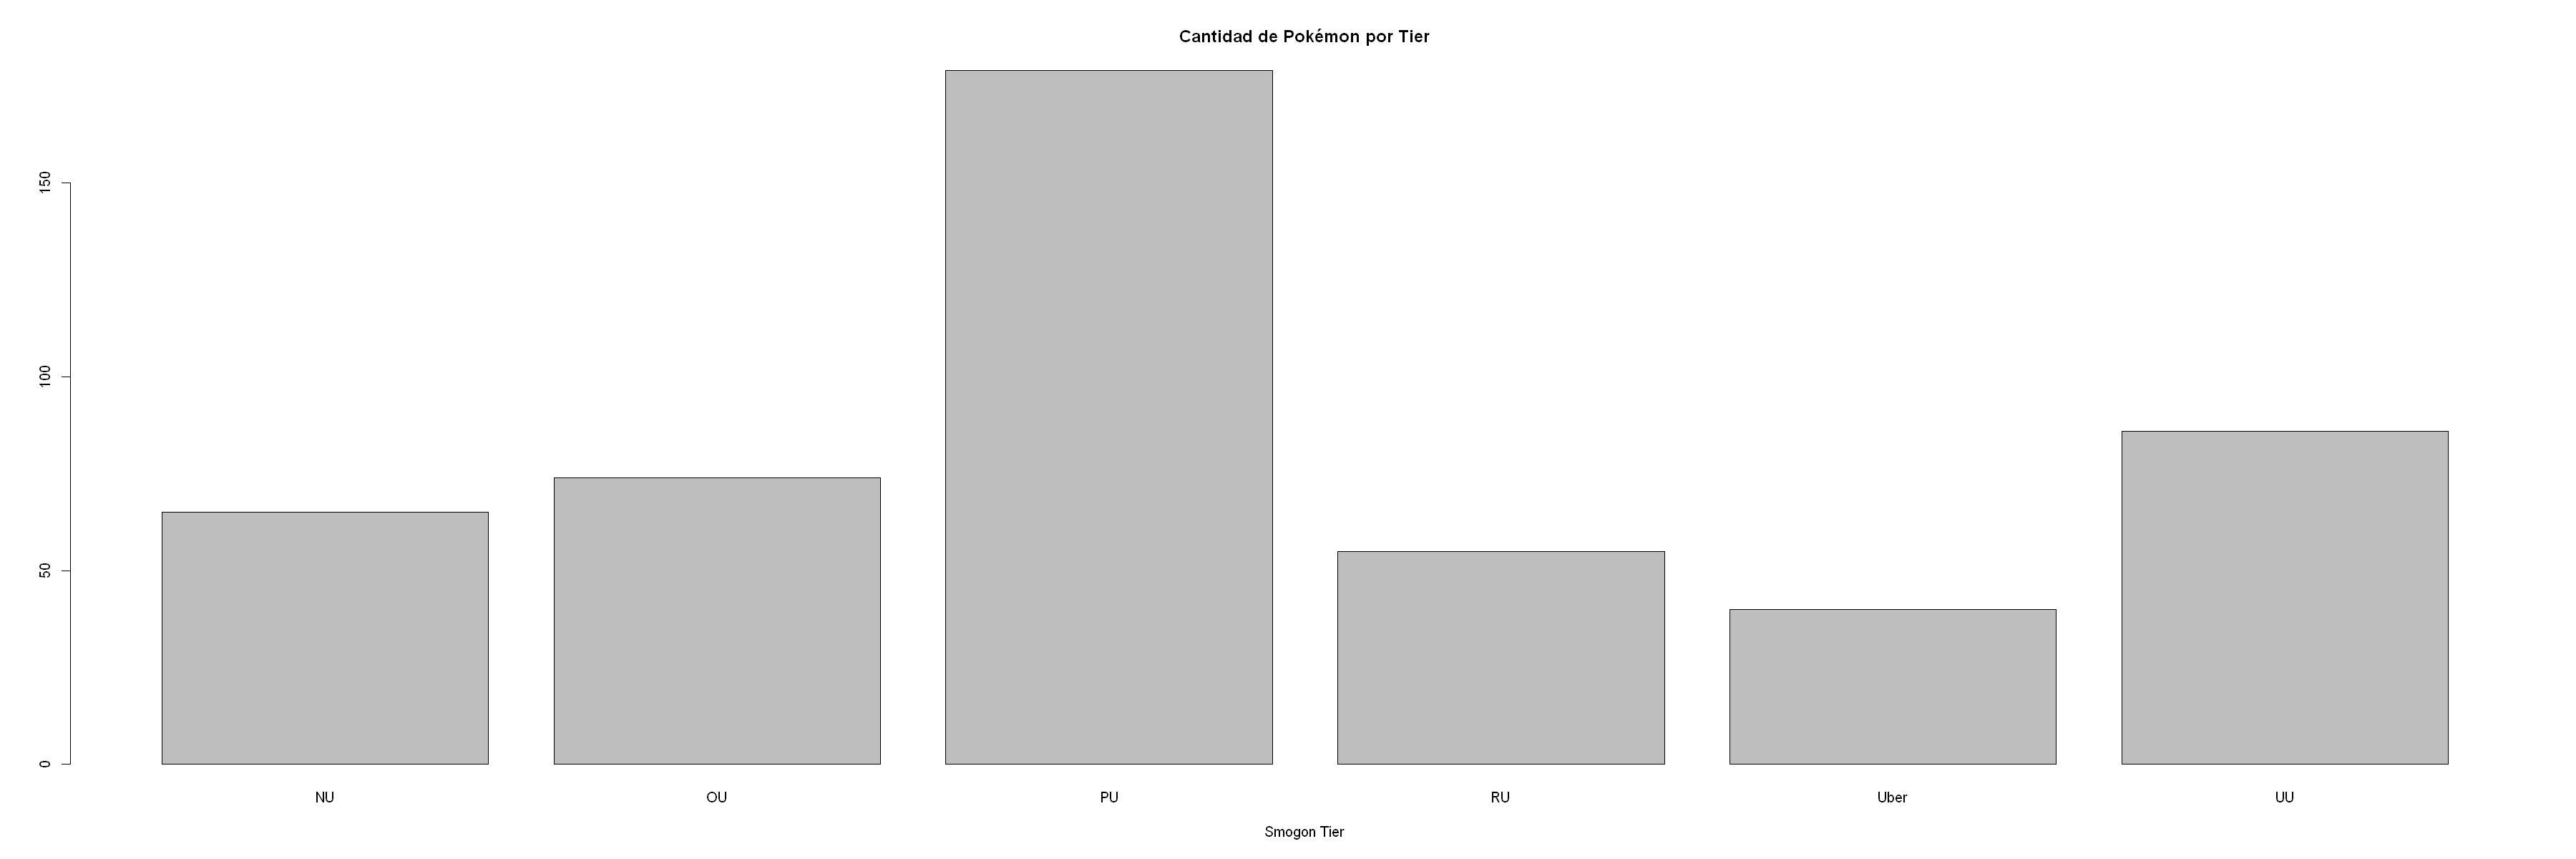

In [8]:
tier_count <- table(data$Tier)
barplot(tier_count, main='Cantidad de Pokémon por Tier',xlab='Smogon Tier')

No solo es importante conocer como se distribuye el atributo a predecir, también es importante ver esta información para cada atributo del dataset. En este caso se omitirán las columnas `DexNum` y `Name` ya que no entregan mucha información. Por temas de espacio solo se realizarán dos gráficos.

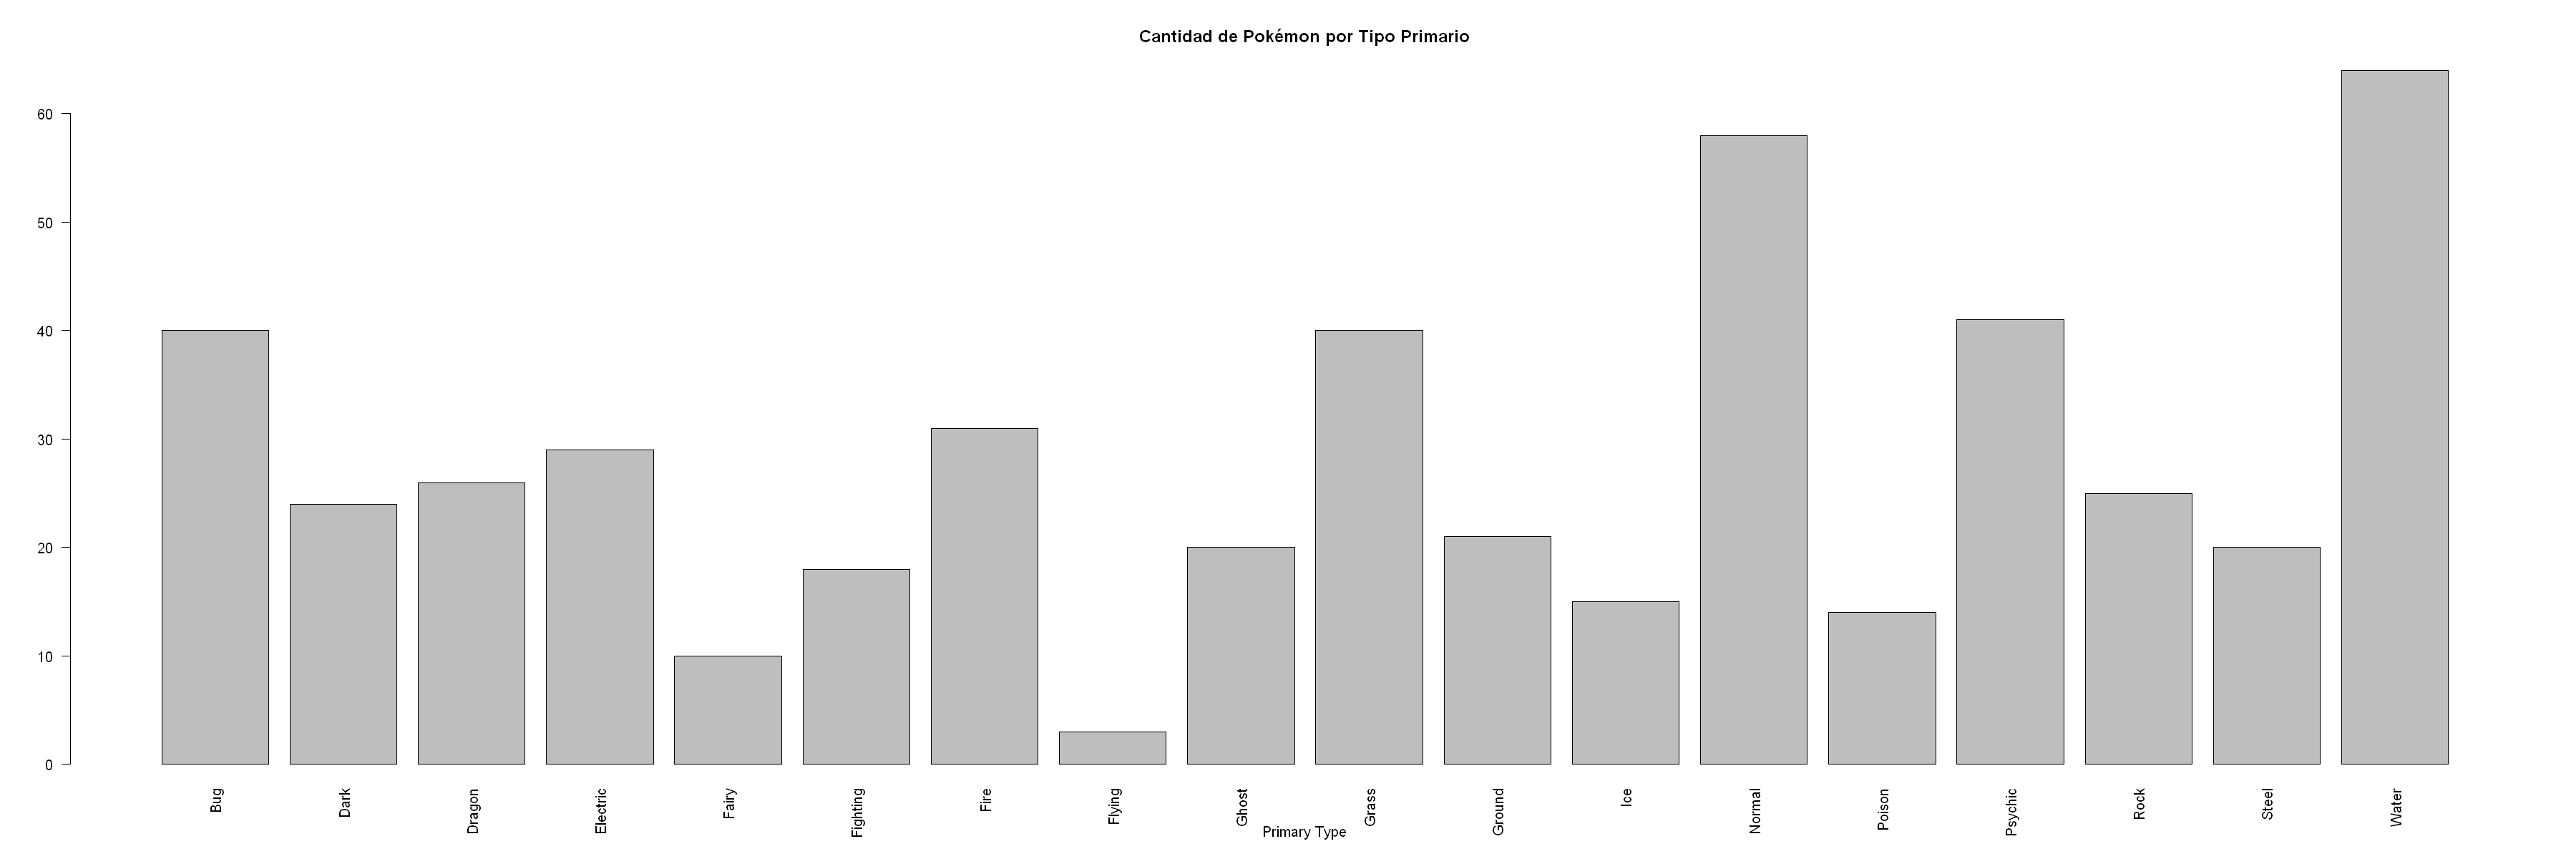

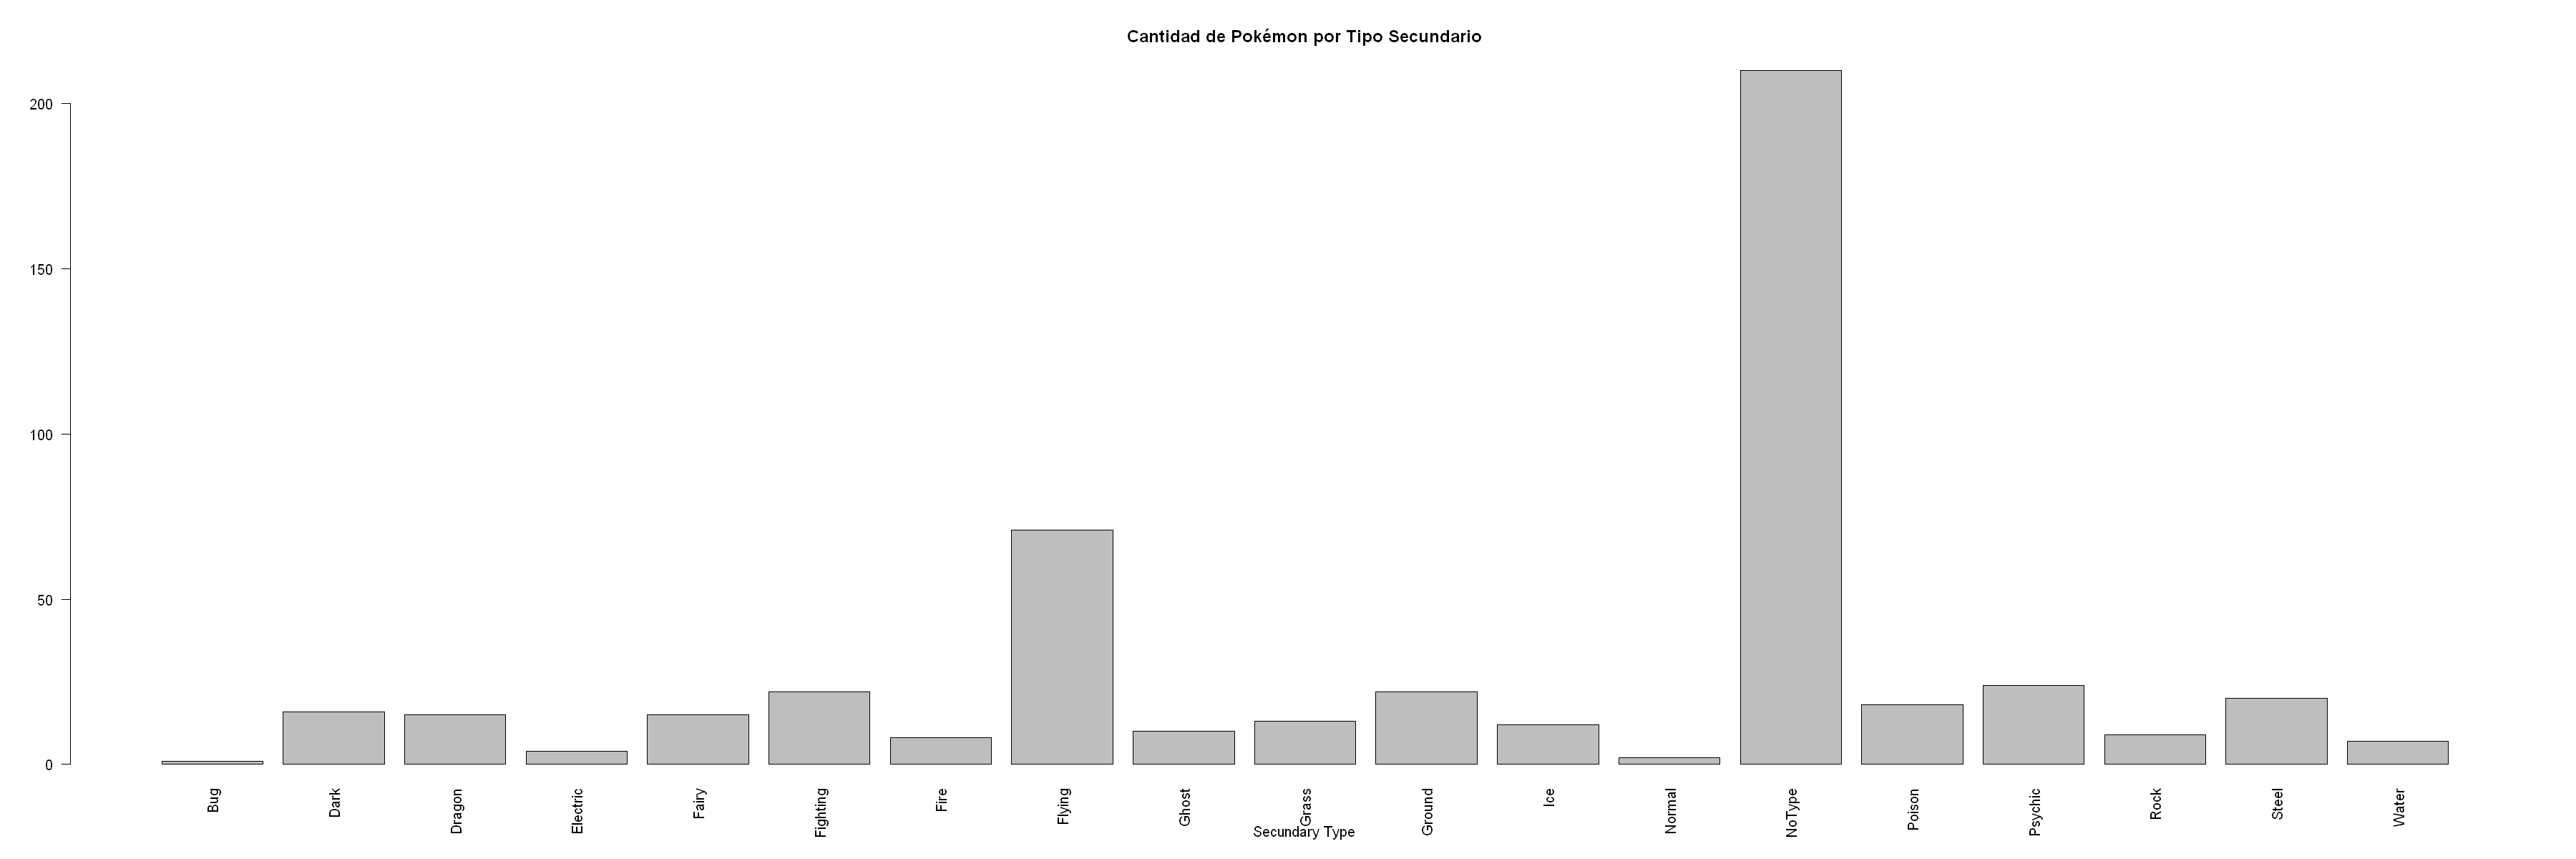

In [9]:
type1_count <- table(data$Type1)
barplot(type1_count, main='Cantidad de Pokémon por Tipo Primario',xlab='Primary Type',las=2)

type2_count <- table(data$Type2)
barplot(type2_count, main='Cantidad de Pokémon por Tipo Secundario',xlab='Secundary Type',las=2)


Como las columnas de stats son numéricas se utilizarán histogramas para observar como se distribuyen. Solo se graficarán dos stats, nuevamente por temas de espacio.

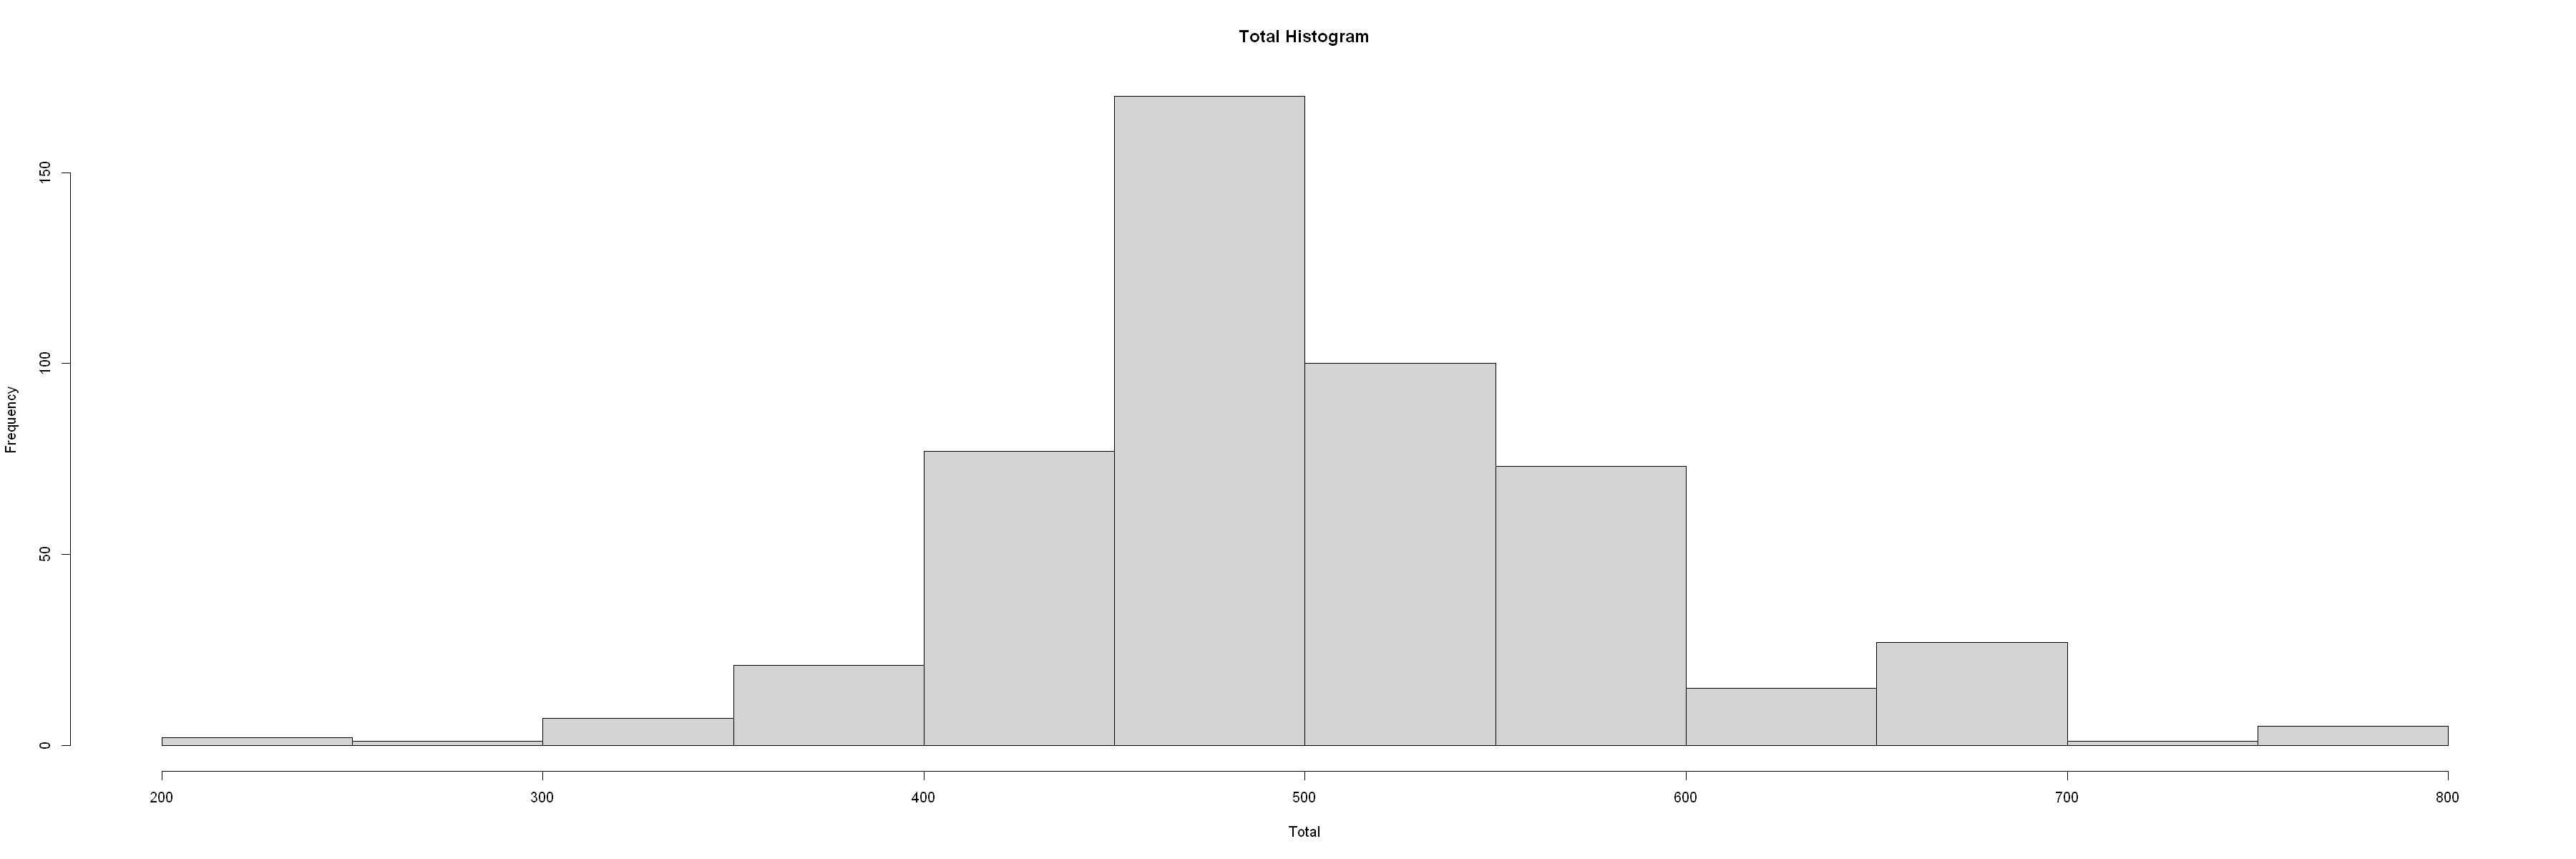

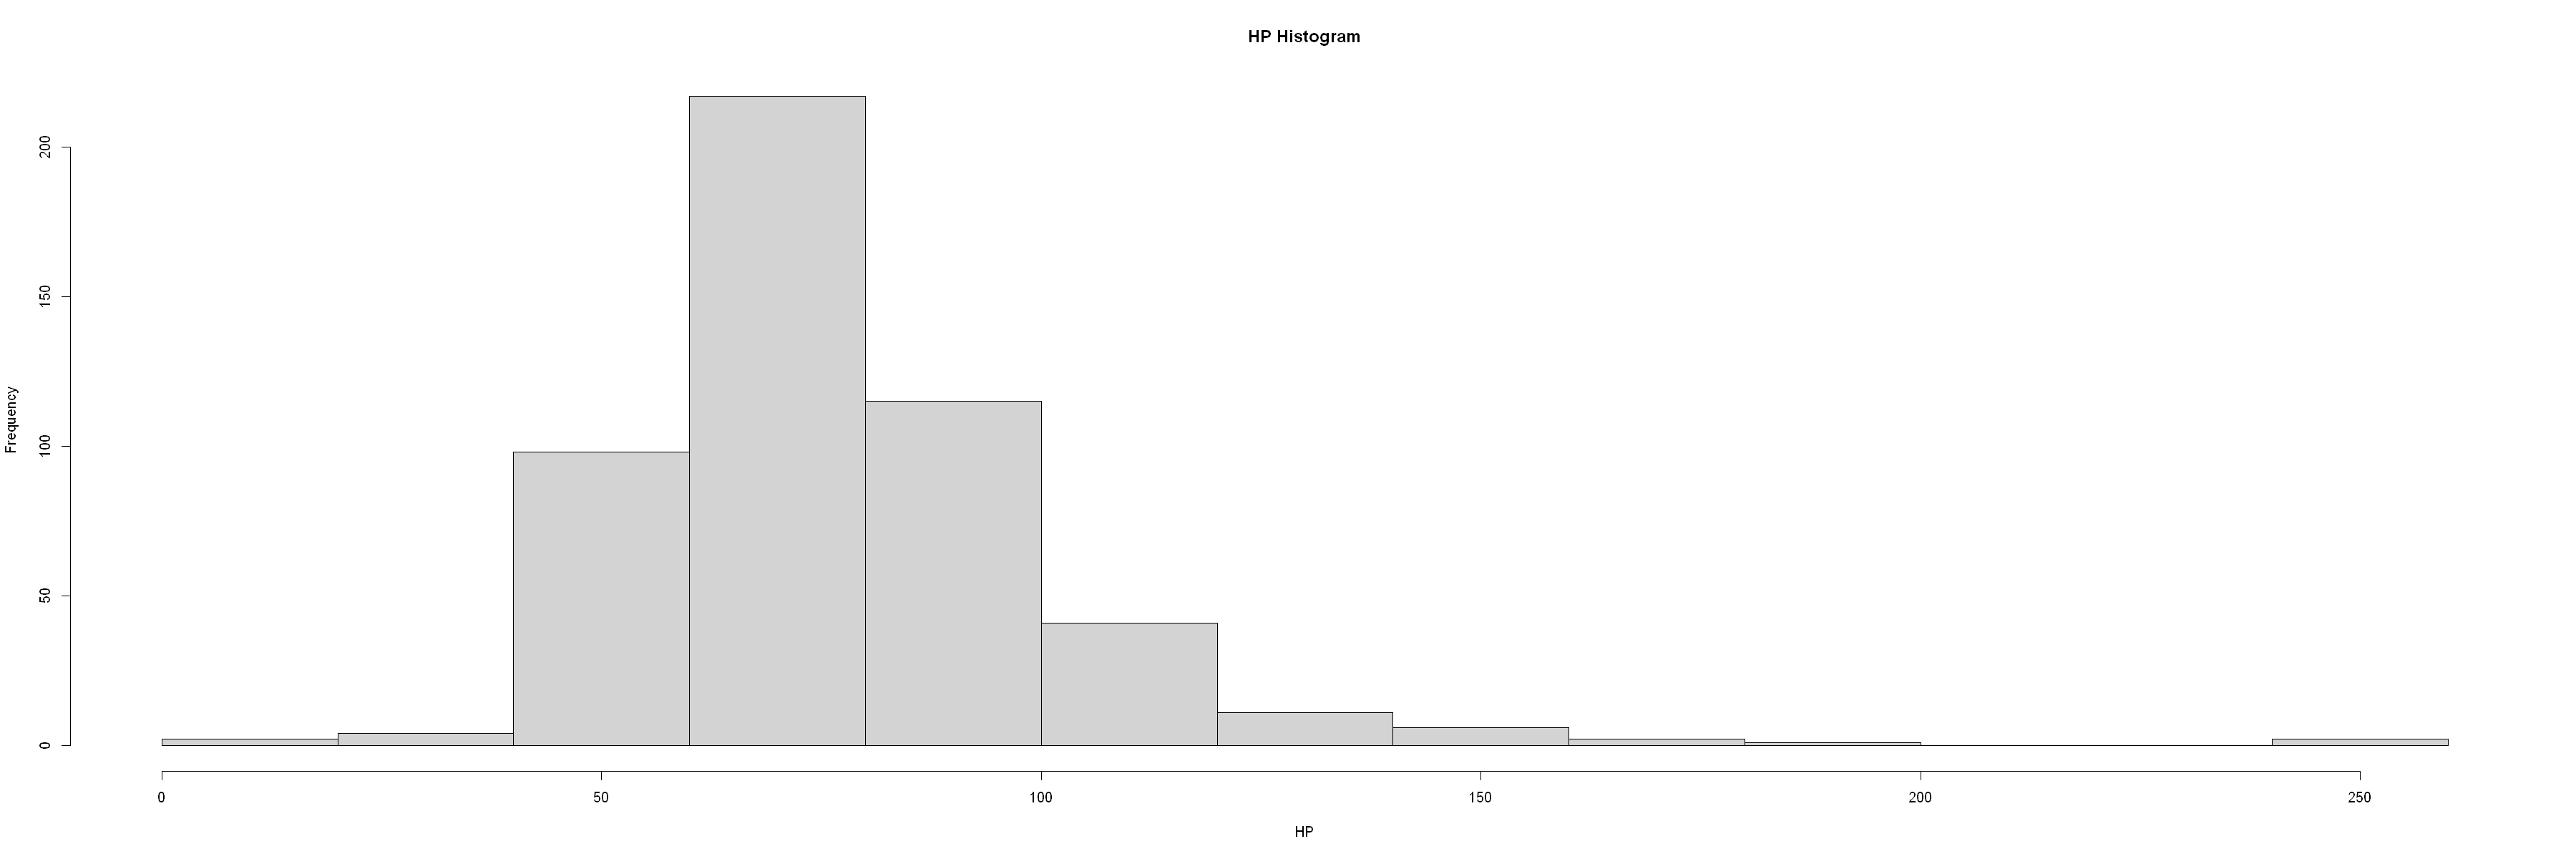

In [10]:
hist(data$Total, main='Total Histogram',xlab='Total')
hist(data$HP, main='HP Histogram',xlab='HP')

### Distribución por cada clase

Una cosa interesante de ver es si existe alguna diferencia entre los stats de los Pokémon de cada Tier. Esto lo podemos comparar utilizando Boxplot por cada uno de los stats.

Para esto, instalemos la librería `ggplot2`, la cual hace mucho más sensilla la tarea de crear visualizaciones.

In [11]:
install.packages('ggplot2')

Installing package into 'C:/Users/felip/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\felip\AppData\Local\Temp\RtmpqwIa6H\downloaded_packages


In [12]:
library(ggplot2)

En este caso se creará un boxplot para comparar el atributo `Total`. Para esto debemos utilizar la función `ggplot` y la función `geom_boxplot`.

Queremos que el eje X de nuestro boxplot sea cada una de nuestras Tiers, lo cual indicamos con `x=Tier` en el segundo parámetro de `ggplot`. El eje Y se lo indicamos con `y=Total`, mientras que los parámetros `color` y `fill` sirven para cambiar el estilo del gráfico. Finalmente con la función `geom_boxplot` indicamos que queremos realizar dicho gráfico, cuyo parámetro alpha controla la transparencia de los colores utilizados.

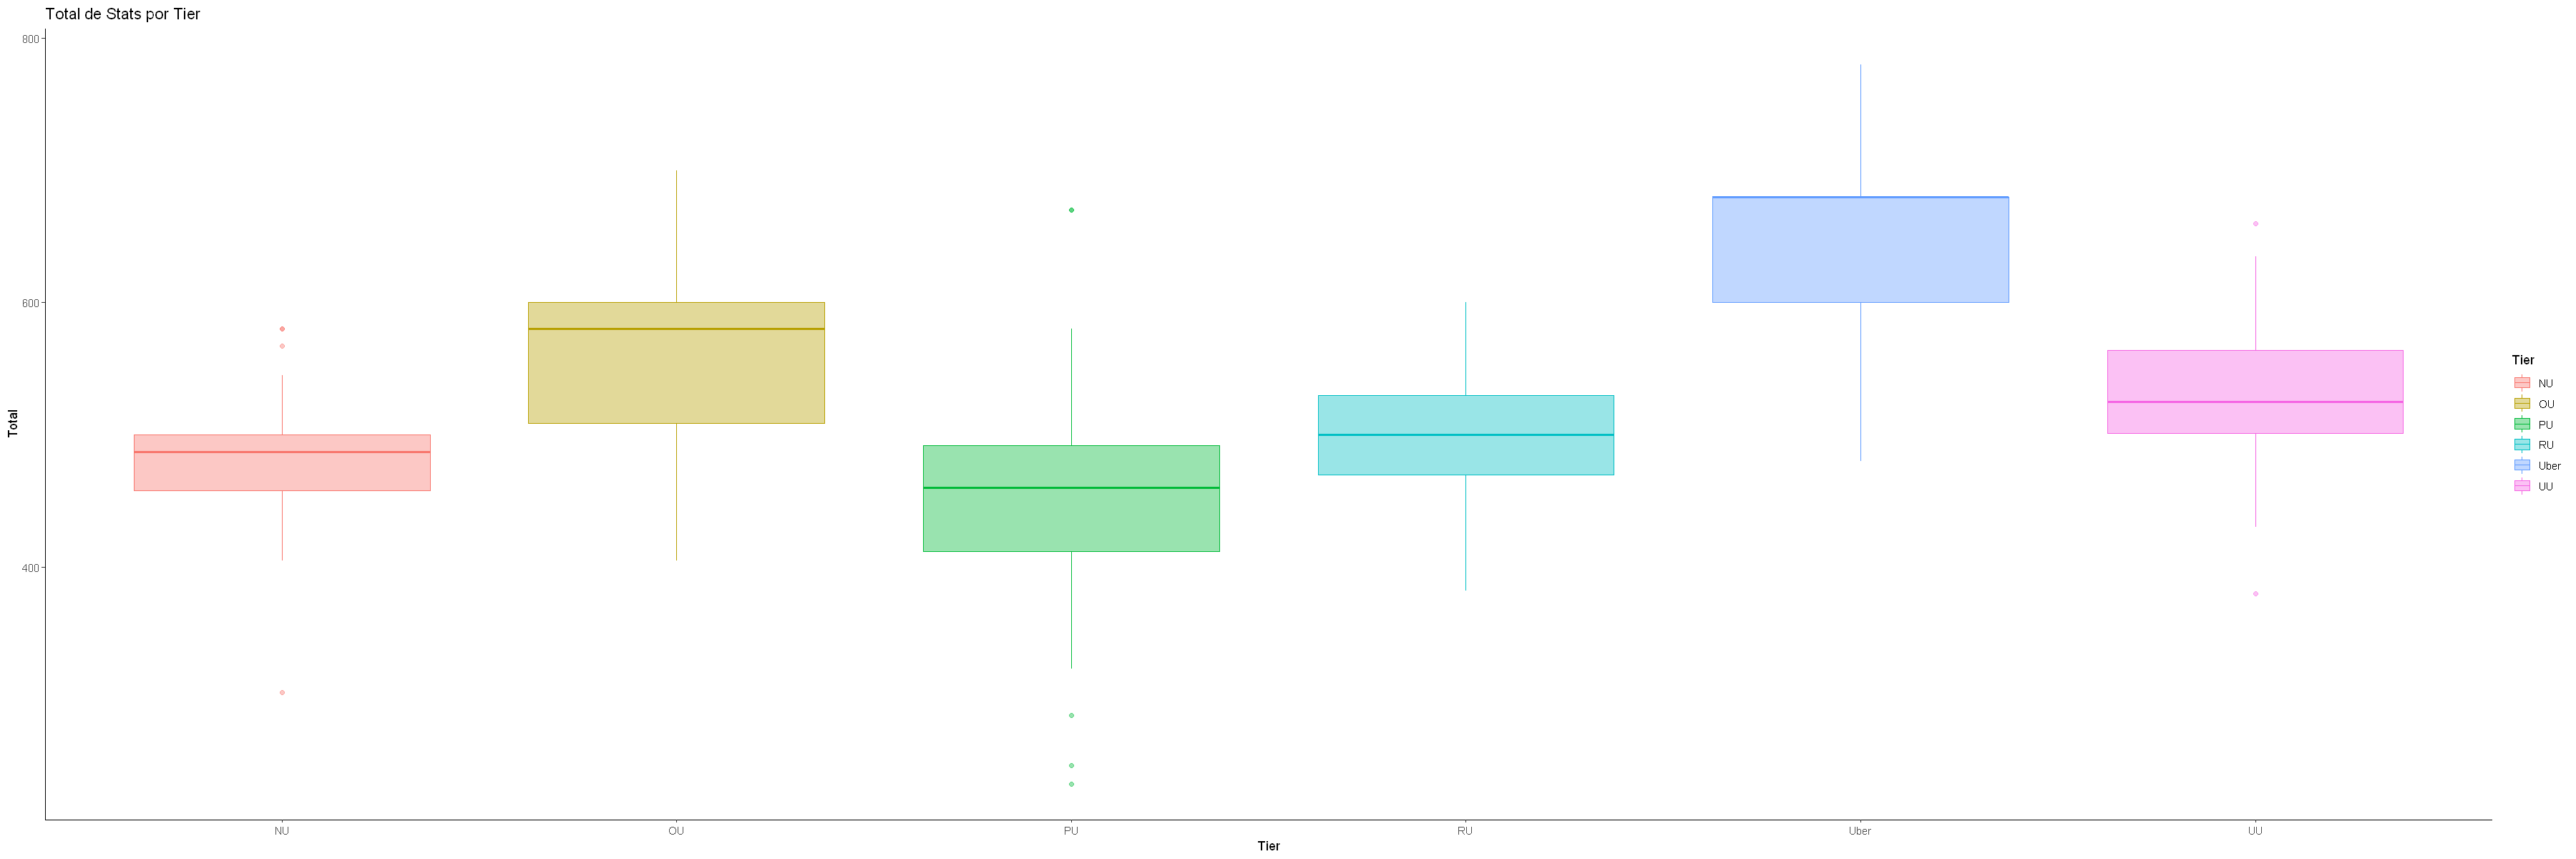

In [13]:
ggplot(data, aes(x=Tier,color=Tier,y=Total,fill=Tier)) + 
    geom_boxplot(alpha=0.4) +
    labs(title="Total de Stats por Tier") + theme_classic()

¿Será una buena idea realizar una partición por este atributo?

Se podrían realizar muchas otras visualizaciones para comprender nuestro dataset. Algunas podrían indicarnos que es necesario realizar algunas transformaciones en algunos atributos, como cambios de escalas por poner un ejemplo, pero dicha labor se escapa del enfoque de este curso.

# Manos a la obra

## Transformación de la variable a predecir

La librería `tree` no acepta que el atributo a predecir sea String, es por esto que se cambia de tipo a `factor`, lo que hace que esta columna cambie a una columna categorica. También cambiaremos los otros atributos de tipo String.

In [14]:
data$Tier <- factor(data$Tier)
data$Legendary <- factor(data$Legendary)
data$Mega <- factor(data$Mega)
data$Type1 <- factor(data$Type1)
data$Type2 <- factor(data$Type2)

## Train - Test Split

Algo importante cuando se trabaja con técnicas de aprendizaje es asegurarnos que nuestro modelo logra generalizar de buena manera y no solo funcione con los datos con que lo entrenamos. Una manera de verificar esto es separar nuestro conjunto de datos en dos sub-conjuntos de datos: uno de entrenamiento, para construir el árbol de clasificación; y uno de pruebas, para probar el desempeño de este.

Esto lo podemos realizar de la siguiente manera.

In [15]:
#Seteamos una semilla para replicar resultados
set.seed(42)
#En este caso utilizaremos un conjunto de entrenamiento con el 80% de los datos
train_size <- floor(0.80 * nrow(data)) #El tamaño será el 80% de la cantidad de filas
train_mask <- sample(seq_len(nrow(data)),size= train_size) #Mascara aleatoria
#Separamos los conjuntos
train <- data[train_mask, ]
test <- data[-train_mask, ]

Esto guarda en la variable `train` el $80%$ de los datos, y en `test` el $20%$ restante.

In [16]:
dim(train)

[1] 399  15

In [17]:
dim(test)

[1] 100  15

## Ármando el árbol

Para construir nuestro árbol utilizaremos el método `tree` de la librería del mismo nombre.

In [18]:
arbol = tree(Tier ~ Total + HP + Atk + Def + SAtk + SDef + Spd +
             Generation + Legendary + Mega, data = train)

Utilizaremos dos parámetros para el método `tree`. El primero se conoce como fórmula, donde la primera columna que aparece es la columna que queremos predecir, luego sigue el símbolo ~ para luego colocar todas las columnas que queremos utilizar para construir nuestro árbol. En caso de querer excluir una columna, en este caso `DexNum` y `Name`, es cosa de no agregarla en la fórmula. El segundo parámetro es el conjunto de datos que se utilizará para entrenar el árbol.

_**Nota:**_ Los atributos `Type` fueron excluidos para que en el futuro árbol aparezca el campo Generation. Esto fue realizado para ejemplificar una situación en la siguente sección. 

Una vez construído, podemos ver un resumen del árbol con el comando `summary`.

In [19]:
summary(arbol)


Classification tree:
tree(formula = Tier ~ Total + HP + Atk + Def + SAtk + SDef + 
    Spd + Generation + Legendary + Mega, data = train)
Variables actually used in tree construction:
[1] "Total"      "HP"         "Spd"        "SAtk"       "Def"       
[6] "Generation" "SDef"      
Number of terminal nodes:  17 
Residual mean deviance:  2.138 = 816.8 / 382 
Misclassification error rate: 0.4236 = 169 / 399 

Esto nos muestra la fórmula con la que fue construido el árbol, los atributos utilizados para la construcción del árbol, el error de clasificación, entre otras.

Una de las ventajas que tiene un árbol de clasificación por sobre otras técnicas de aprendizaje automático es que podemos visualizar este para ver como es que se llega a una determinada predicción.

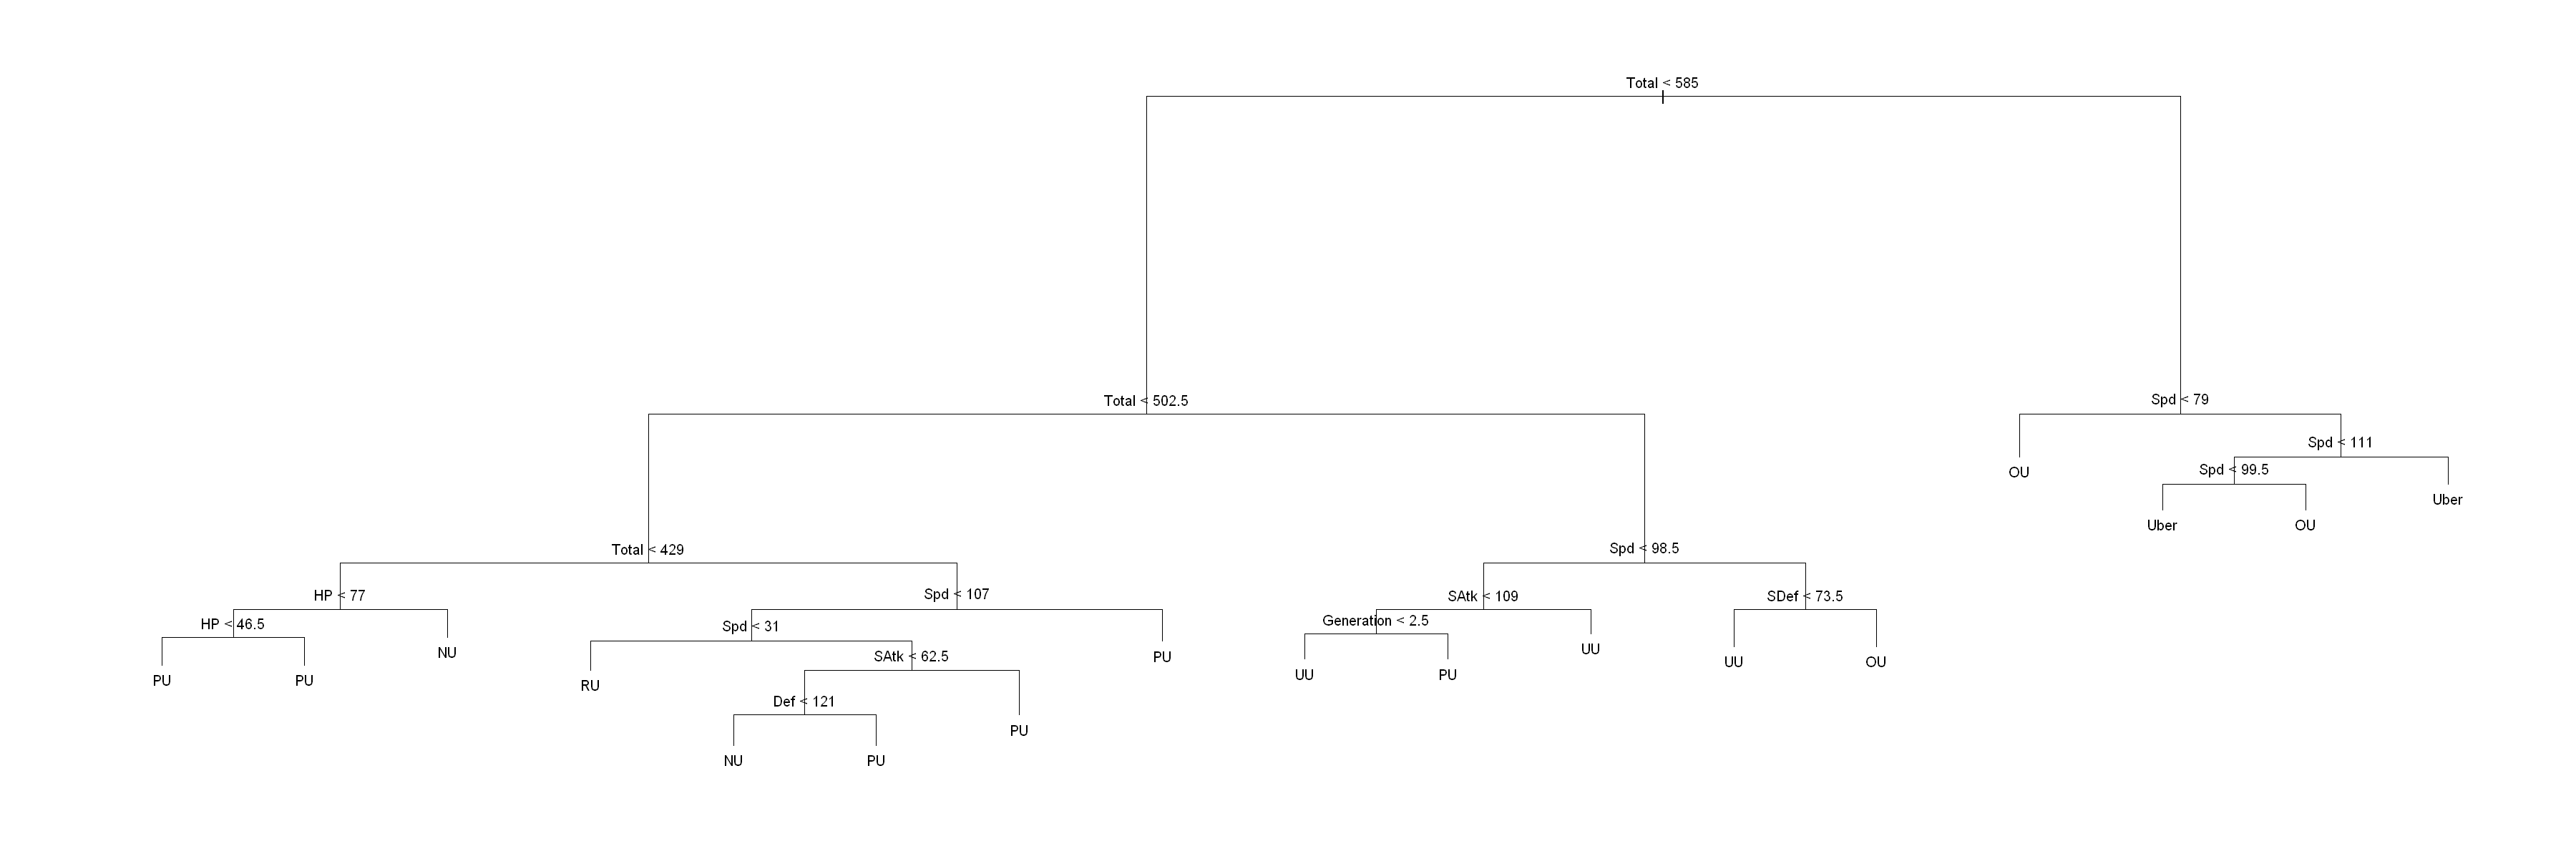

In [20]:
plot(arbol)
text(arbol,pretty=1)

Si la condición del nodo se cumple, se sigue con la rama izquierda, caso contrario se sigue la rama derecha.

## Discretización

Viendo la imagen anterior podemos notar una partición un poco rara, dado que no es posible que un Pokémon pertenezca a la generación 2.5 (ignoremos Pokémon presentados anticipadamente en el anime). Para arreglar esta situación debemos cambiar a categorica la variable `Generation`, tal como lo hicimos con las variables de tipo String.

In [21]:
data$Generation <- factor(data$Generation)

Repetimos el proceso anterior para obtener un nuevo árbol.

In [22]:
#Seteamos una semilla para replicar resultados
set.seed(42)
#En este caso utilizaremos un conjunto de entrenamiento con el 80% de los datos
train_size <- floor(0.80 * nrow(data)) #El tamaño será el 80% de la cantidad de filas
train_mask <- sample(seq_len(nrow(data)),size= train_size) #Mascara aleatoria
#Separamos los conjuntos
train <- data[train_mask, ]
test <- data[-train_mask, ]

arbol_discretizado = tree(Tier ~ Total +
             HP + Atk + Def + SAtk + SDef + Spd +
             Generation + Legendary + Mega, data = train)

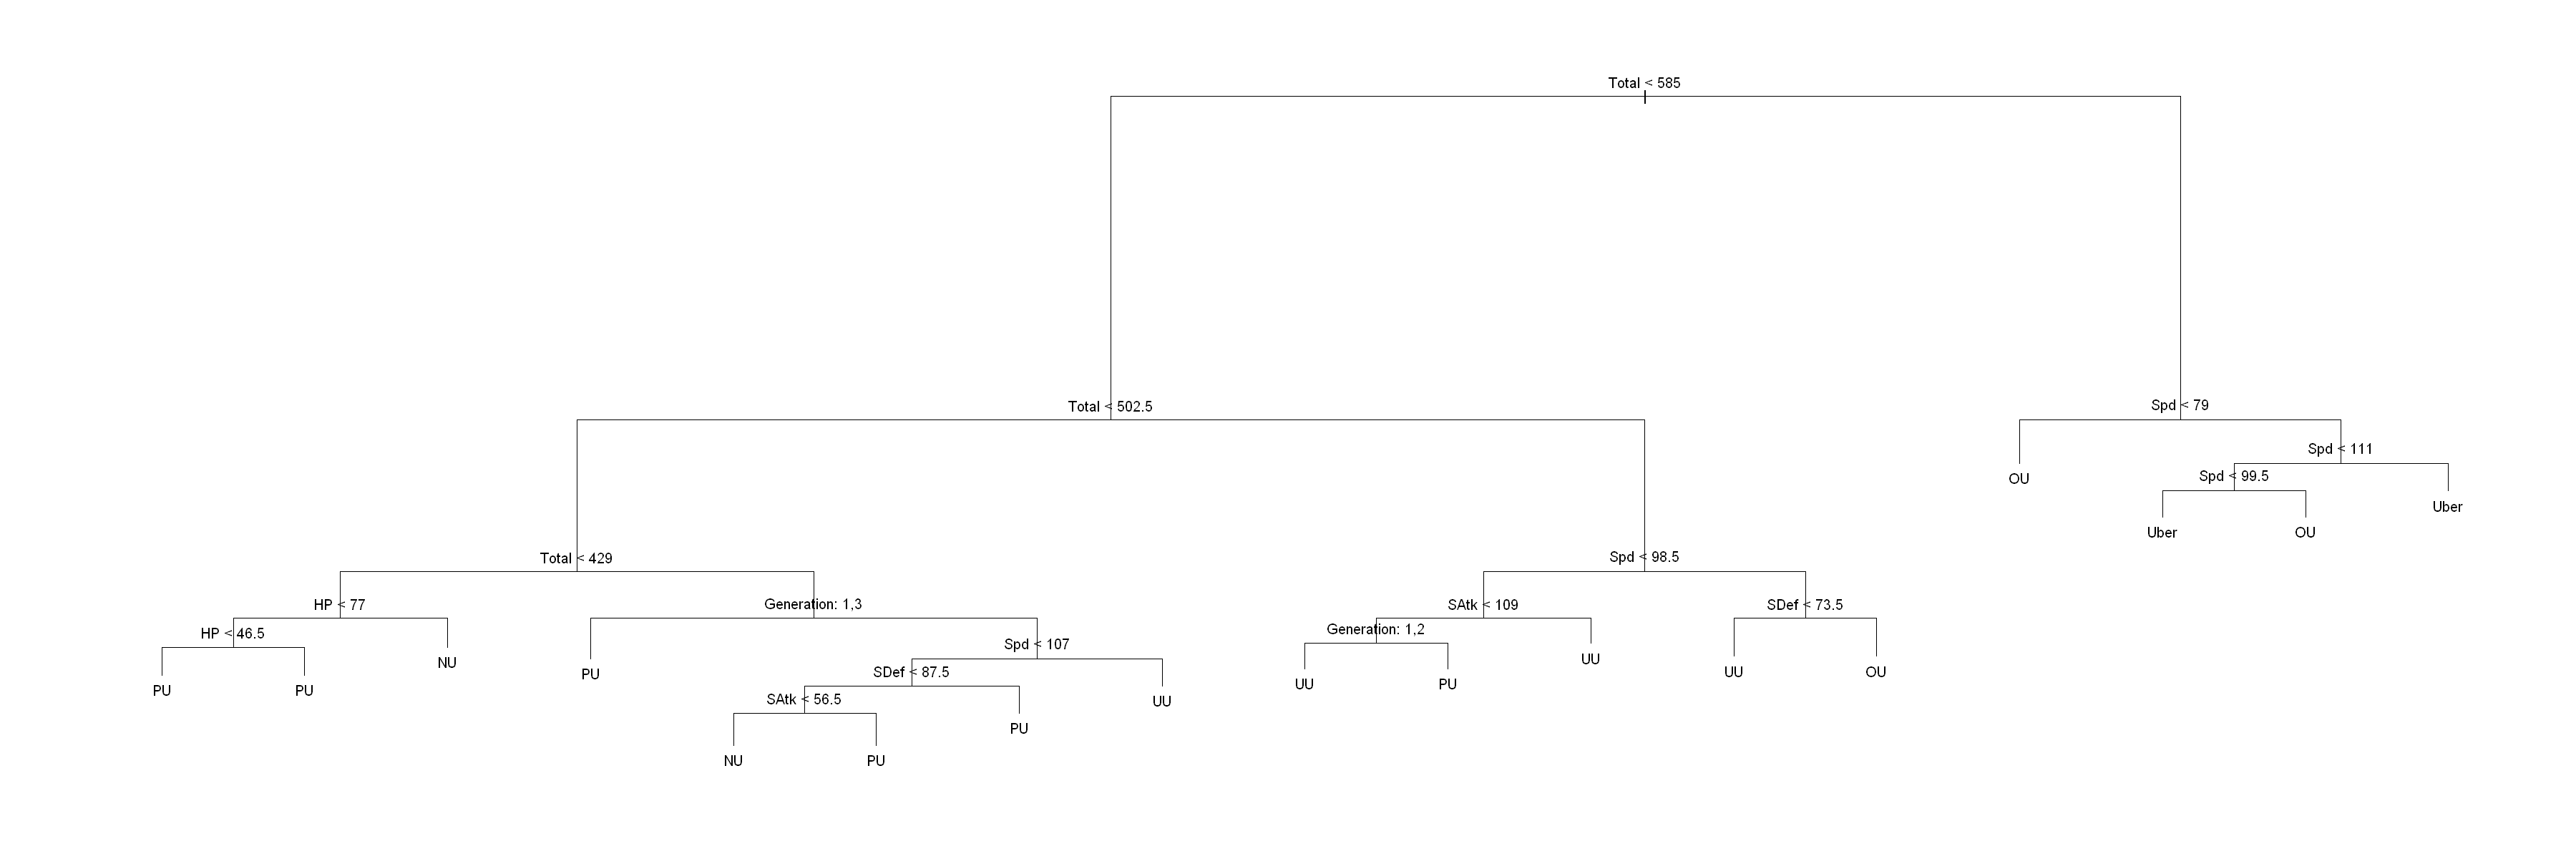

In [23]:
plot(arbol_discretizado)
text(arbol_discretizado,pretty=1)

Ahora, dicha partición se realiza si el Pokémon pertenece a la generación 1 o 2.

_**Nota:**_ Los Stats en el juego no pueden tomar valores intermedios por lo que también deberían ser discretizados. Sin embargo, el módulo `tree` solo permite variables categóricas con menos de 32 valores posibles dado que aumenta mucho el procesamiento computacional necesario para probar los posibles splits. Lo que se debería hacer en este caso es agrupar dichos valores en niveles, por ejemplo, separar un stat en alto, medio y bajo. Esto no se realiza ya que se escapa un poco de lo que les pedirán en el control.

## Viendo el árbol más a fondo

Con las siguientes instrucciones se pueden ver más detalles del árbol, incluyendo cuantos datos existen en cada partición, la probabilidad de cada clase en cada partición, y la predicción que se haría en cada nodo de ser un nodo terminal. Con estos valores podrían calcular la impureza que tiene cada nodo.

In [24]:
arbol_discretizado

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 399 1327.00 PU ( 0.137845 0.155388 0.358396 0.110276 0.075188 0.162907 )  
    2) Total < 585 332 1001.00 PU ( 0.165663 0.096386 0.430723 0.123494 0.015060 0.168675 )  
      4) Total < 502.5 227  583.50 PU ( 0.189427 0.061674 0.559471 0.105727 0.008811 0.074890 )  
        8) Total < 429 62   89.70 PU ( 0.096774 0.048387 0.806452 0.032258 0.000000 0.016129 )  
         16) HP < 77 52   53.15 PU ( 0.038462 0.019231 0.884615 0.038462 0.000000 0.019231 )  
           32) HP < 46.5 6   12.14 PU ( 0.333333 0.166667 0.500000 0.000000 0.000000 0.000000 ) *
           33) HP > 46.5 46   26.00 PU ( 0.000000 0.000000 0.934783 0.043478 0.000000 0.021739 ) *
         17) HP > 77 10   21.10 NU ( 0.400000 0.200000 0.400000 0.000000 0.000000 0.000000 ) *
        9) Total > 429 165  468.60 PU ( 0.224242 0.066667 0.466667 0.133333 0.012121 0.096970 )  
         18) Generation: 1,3 66  167.50 PU ( 0.333333 0.060606 0.4848

In [25]:
arbol_discretizado$frame

,var,n,dev,yval,splits,yprob
,<fct>,<dbl>,<dbl>,<fct>,"<chr[,2]>","<dbl[,6]>"
1,Total,399,1327.49546,PU,"<585 , >585","0.13784461, 0.15538847, 0.3583960, 0.11027569, 0.075187970, 0.16290727"
2,Total,332,1001.17563,PU,"<502.5, >502.5","0.16566265, 0.09638554, 0.4307229, 0.12349398, 0.015060241, 0.16867470"
4,Total,227,583.49855,PU,"<429 , >429","0.18942731, 0.06167401, 0.5594714, 0.10572687, 0.008810573, 0.07488987"
8,HP,62,89.69699,PU,"<77 , >77","0.09677419, 0.04838710, 0.8064516, 0.03225806, 0.000000000, 0.01612903"
16,HP,52,53.14916,PU,"<46.5 , >46.5","0.03846154, 0.01923077, 0.8846154, 0.03846154, 0.000000000, 0.01923077"
32,<leaf>,6,12.13685,PU,",","0.33333333, 0.16666667, 0.5000000, 0.00000000, 0.000000000, 0.00000000"
33,<leaf>,46,25.99921,PU,",","0.00000000, 0.00000000, 0.9347826, 0.04347826, 0.000000000, 0.02173913"
17,<leaf>,10,21.09840,NU,",","0.40000000, 0.20000000, 0.4000000, 0.00000000, 0.000000000, 0.00000000"
9,Generation,165,468.55305,PU,":ac , :bdef","0.22424242, 0.06666667, 0.4666667, 0.13333333, 0.012121212, 0.09696970"


## Evaluación

Finalmente, evaluamos el comportamiento de nuestro árbol en el conjunto de pruebas. Pero antes de eso voy a agregar los atributos del tipo de cada Pokémon, ya que dichos campos aumentan el desempeño del árbol.

In [26]:
arbol_completo = tree(Tier ~ Type1 + Type2 + Total +
             HP + Atk + Def + SAtk + SDef + Spd +
             Generation + Legendary + Mega, data = train)

In [27]:
summary(arbol_completo)


Classification tree:
tree(formula = Tier ~ Type1 + Type2 + Total + HP + Atk + Def + 
    SAtk + SDef + Spd + Generation + Legendary + Mega, data = train)
Variables actually used in tree construction:
[1] "Total"      "Type2"      "Type1"      "Spd"        "Generation"
[6] "SDef"       "Def"       
Number of terminal nodes:  24 
Residual mean deviance:  1.63 = 611.2 / 375 
Misclassification error rate: 0.3183 = 127 / 399 

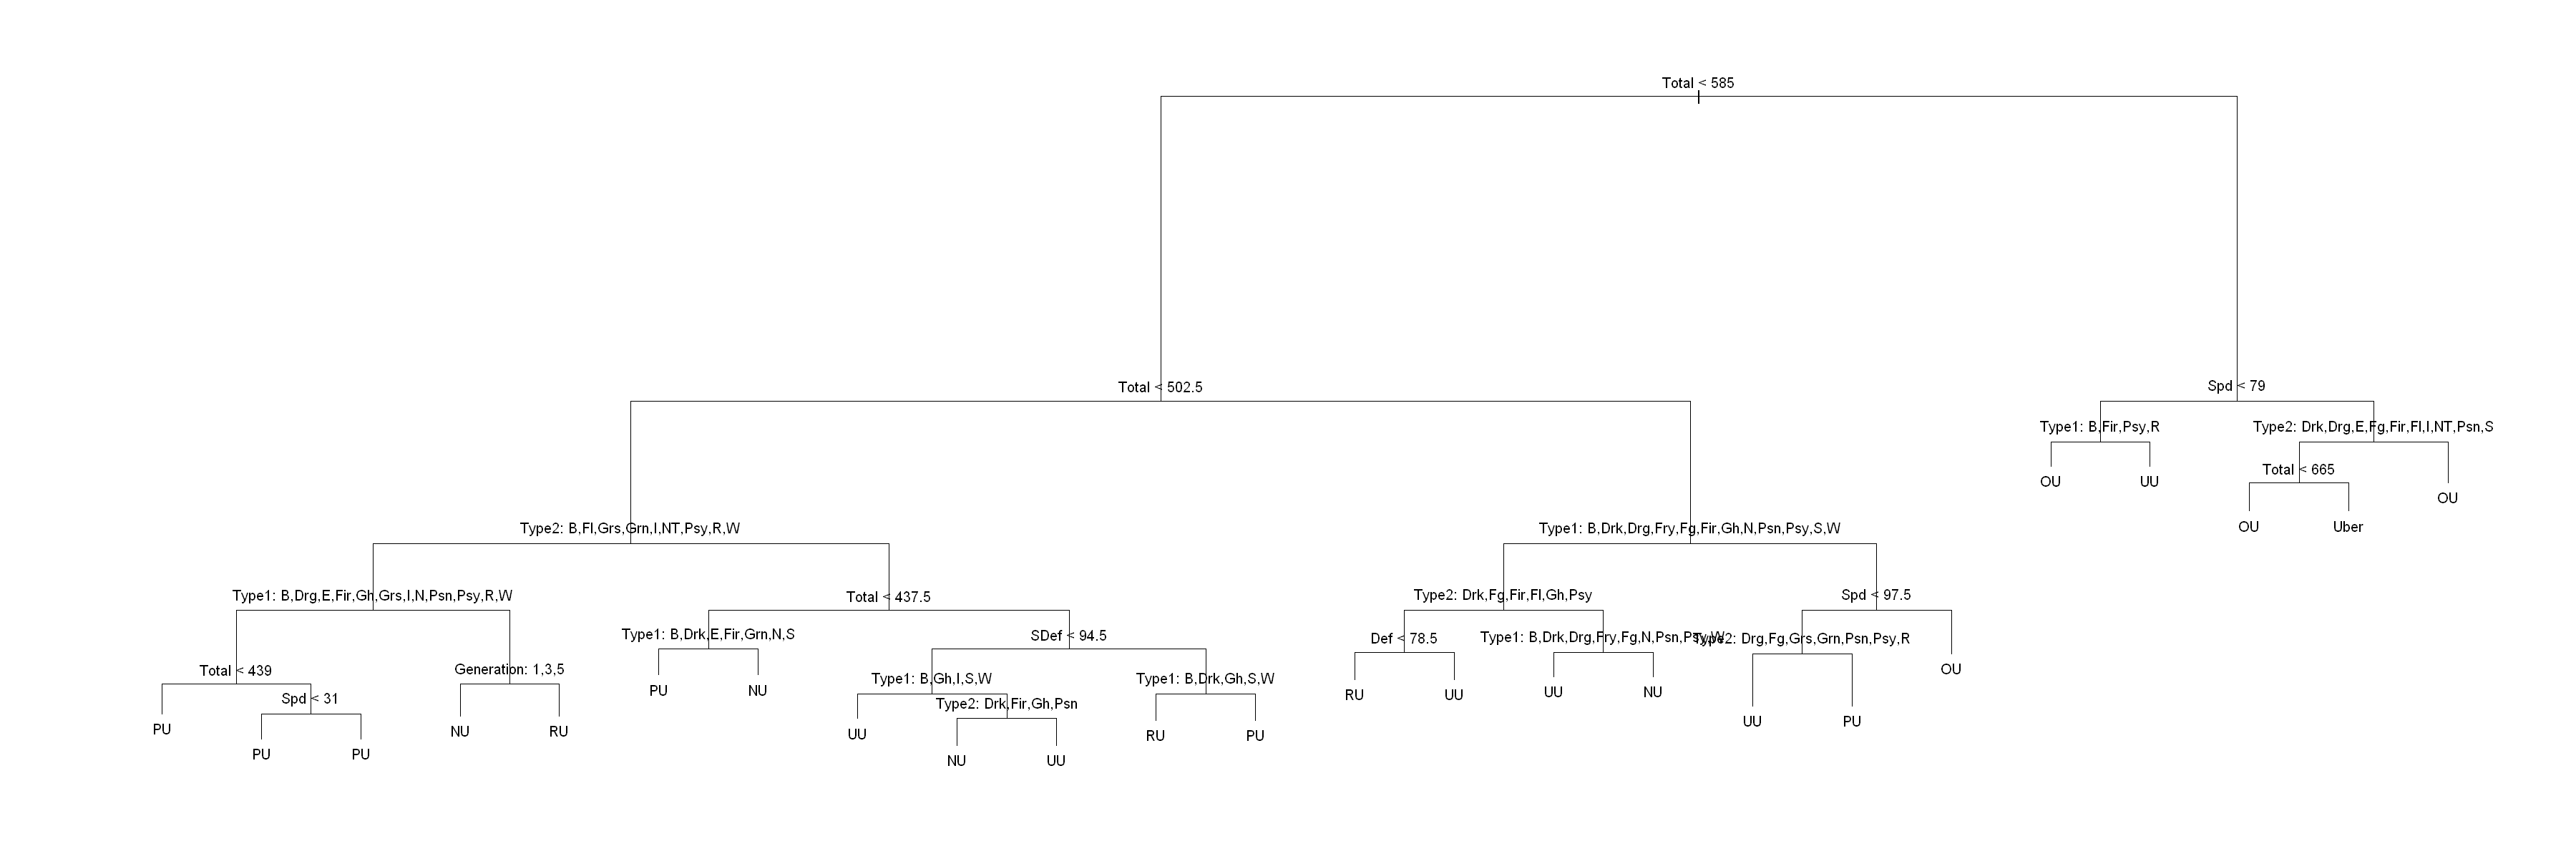

In [28]:
plot(arbol_completo)
text(arbol_completo,pretty=1)

Para evaluar crearemos una matriz de confusión, la cual nos mostrará cuantos datos fueron bien o mal clasificados, esto para cada una de nuestras clases.

In [29]:
# Predecimos cada tier para los datos de pruebas
pred <- predict(arbol_completo,test,type='class')
# Creamos la matriz de confusión
conf_matrix <- with(test,table(pred,test$Tier))

In [30]:
conf_matrix

      
pred   NU OU PU RU Uber UU
  NU    1  1  4  2    0  1
  OU    1  4  0  1    3  7
  PU    3  3 28  4    0  3
  RU    3  1  2  1    0  1
  Uber  0  0  2  0    7  1
  UU    2  3  0  3    0  8

Esta matriz nos muestra los valores predichos (en las filas) y los valores reales (columnas). Por ejemplo, el valor [0][1] de la matriz corresponde a los Pokémon que fueron clasificados como NU, pero en verdad eran OU.

De acá podemos ver para los Pokémon pertenecientes de PU, el modelo clasificó correctamente 28 Pokémon, y se equivocó en 8 (4 en NU, 2 en RU y 2 en Uber). En Uber también el modelo presenta un buen desempeño, pero en las otras tiers el modelo se equivoca más de lo que acierta.

Con esta matriz podemos calcular el `accuracy` del modelo, sumando la diagonal (aciertos) y dividiendolo por la cantidad de datos en el conjunto. El error de clasificación se puede calcular como $1 - accuracy$.

In [31]:
acc <- sum(diag(conf_matrix))/nrow(test)
miss_class_error <- 1 - acc

In [32]:
acc

[1] 0.49

In [33]:
miss_class_error

[1] 0.51

Podemos ver que el modelo presenta un 51% de error de clasificación en el conjunto de pruebas, pero en el conjunto de entrenamiento tenía un 32% (ver summary(arbol)). Esto nos indica que el modelo está sobreajustado a los datos de entrenamiento.

Hay distintas maneras con la cual se podría atacar este sobreajuste: limitar la altura del árbol al momento de construirlo, podarlo una vez construido, agregar más datos, etc. También el conocimiento del dominio te podría ayudar, muchas veces en el Pokémon Competitivo no importan tan solo los stats que tiene un Pokémon, también toman mucha relevancia los ataques que tiene un Pokémon o la habilidad. Agregar dichos datos podría llegar a mejorar los resultados obtenidos por nuestro árbol.

# Cambios sobre el dataset original

- Cambio en los nombres de las columnas.
- Relleno de valores faltantes en columna Type2, ya que no todos los Pokémon tienen segundo tipo.
- Cambio del nombre de Farfetch'd a Farfetch.
- Quien conoce un poco de las tiers de Smogon sabe que estas incluyen Ban List para cada tiers, estas las modifiqué agregando cada Pokémon de una determinada Ban List a la tier siguiente. En el caso de Mega-Rayquaza, fue incluído dentro de Uber. Esto fue realizado para disminuir el número de clases, ya que tener más clases complejiza el problema.